In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from src.utils import get_best_t
from src.utils import get_theory_curves
from src.data_load import load_minimum, collect_minima

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 14,
    'style'  : 'normal'}
matplotlib.rc('font', **font)

In [3]:
# -------------------------------------------------------------------
# States / conditions per dataset
# -------------------------------------------------------------------

states_zhang = ["mid_G1", "late_G1"]
states_abramo = ["4h", "5h", "6h", "7h"]

states_bonev = [
    "HiC_CN_1.mm10.mapq_30.1000.mcool",
    "HiC_CN_2.mm10.mapq_30.1000.mcool",
    "HiC_CN_3.mm10.mapq_30.1000.mcool",
    "HiC_CN_4.mm10.mapq_30.1000.mcool",
    "HiC_CN_5.mm10.mapq_30.1000.mcool",
    "HiC_CN_6.mm10.mapq_30.1000.mcool",
    "HiC_ES_1.mm10.mapq_30.1000.mcool",
    "HiC_ES_2.mm10.mapq_30.1000.mcool",
    "HiC_ES_3.mm10.mapq_30.1000.mcool",
    "HiC_ES_4.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_1.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_2.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_3.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_4.mm10.mapq_30.1000.mcool",
]

states_rao = [
    "GM12878_inSitu_DpnII.hg38.mapq_30.1000.mcool",
    "HMEC_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "HUVEC_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "IMR90_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "K562_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "KBM7_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "NHEK_inSitu_MboI.hg38.mapq_30.1000.mcool",
]

states_hff = [
    "U54-HFFc6-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
    "hg38_deep",
]

states_esc = [
    "U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
    "U54-ESC4DN-FA-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
]

states_wutz = ["control.hg38.mapq_30.1000.mcool"]
states_schwarzer = ["TAM.mm10.mapq_30.1000.mcool"]



In [5]:
data_dir = "../data"

# Abramo (HeLa, mitotic exit time course)
xs_abramo, ys_abramo = collect_minima("abramo", states_abramo, data_dir)

# Zhang (mESC, mitotic exit time course)
xs_zhang, ys_zhang = collect_minima("zhang", states_zhang, data_dir)

# Bonev (CN/ES)
xs_bonev, ys_bonev = collect_minima("bonev", states_bonev, data_dir)

# Rao (GM12878 etc.)
xs_rao, ys_rao = collect_minima("rao", states_rao, data_dir)

# Oksuz HFF (HFF)
xs_hff, ys_hff = collect_minima("oksuz_hff", states_hff, data_dir)

# Oksuz ESC (hESC protocols)
xs_esc, ys_esc = collect_minima("oksuz_esc", states_esc, data_dir)

# Wutz (control)
xs_wutz, ys_wutz = collect_minima("wutz", states_wutz, data_dir)

# Schwarzer (TAM control)
xs_sch, ys_sch = collect_minima("schwarzer", states_schwarzer, data_dir)

In [6]:
dataset_styles = {
    "Rao":      dict(xs=xs_rao,    ys=ys_rao,    states=states_rao),
    "Bonev":    dict(xs=xs_bonev,  ys=ys_bonev,  states=states_bonev),
    "Oksuz HFF":dict(xs=xs_hff,    ys=ys_hff,    states=states_hff),
    "Oksuz ESC":dict(xs=xs_esc,    ys=ys_esc,    states=states_esc),
    "Wutz":     dict(xs=xs_wutz,   ys=ys_wutz,   states=states_wutz),
    "Schwarzer":dict(xs=xs_sch,    ys=ys_sch,    states=states_schwarzer),
    "Zhang":    dict(xs=xs_zhang,  ys=ys_zhang,  states=states_zhang),
    "Abramo":   dict(xs=xs_abramo, ys=ys_abramo, states=states_abramo),
}

In [7]:
T_values = np.arange(100, 301, 10)
v0_values = [0.0001, 0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5,
             4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.6,
             10, 10.5, 11, 11.5, 12, 12.5, 13, 14, 15]

In [8]:
# Get theoretical positions and depths of log-derivative minima
# across a grid of loop periods T and effective fragment lengths v0

theory_xmins, theory_ymins, s_grid, v0_values = get_theory_curves()

In [9]:
# Print the optimal parameters for each data

all_T = []
all_v0 = []
all_density = []

for name, style in dataset_styles.items():

    print(f"{name}")

    for x_bp, y_obs, state in zip(style["xs"], style["ys"], style["states"]):
        # convert s_min from bp to kb
        x_kb = x_bp / 1000.0

        T_best, v0_best, err = get_best_t(
            (x_kb, y_obs),
            theory_xmins=theory_xmins,
            theory_ymins=theory_ymins,
            T_values=T_values,
            v0_values=v0_values,
            x_weight=1e-4,
        )
        print(f"{state}")
        print(f"T = {T_best}")
        print(f"v0 = {v0_best}")
        print(f"density = {(1000.0 / T_best):.2f} loops/Mb")
        print(f"error = {err:.6f}")
        print()
        all_T.append(T_best)
        all_v0.append(v0_best)

Rao
GM12878_inSitu_DpnII.hg38.mapq_30.1000.mcool
T = 150
v0 = 3.5
density = 6.67 loops/Mb
error = 0.000149

HMEC_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 140
v0 = 3.5
density = 7.14 loops/Mb
error = 0.000013

HUVEC_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 120
v0 = 7.5
density = 8.33 loops/Mb
error = 0.000074

IMR90_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 140
v0 = 5.0
density = 7.14 loops/Mb
error = 0.000012

K562_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 120
v0 = 5.0
density = 8.33 loops/Mb
error = 0.000035

KBM7_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 170
v0 = 12.0
density = 5.88 loops/Mb
error = 0.000017

NHEK_inSitu_MboI.hg38.mapq_30.1000.mcool
T = 210
v0 = 7.5
density = 4.76 loops/Mb
error = 0.000075

Bonev
HiC_CN_1.mm10.mapq_30.1000.mcool
T = 200
v0 = 8.5
density = 5.00 loops/Mb
error = 0.000024

HiC_CN_2.mm10.mapq_30.1000.mcool
T = 200
v0 = 9.0
density = 5.00 loops/Mb
error = 0.000005

HiC_CN_3.mm10.mapq_30.1000.mcool
T = 200
v0 = 8.5
density = 5.00 loops/Mb
error = 0.000027

HiC_CN_

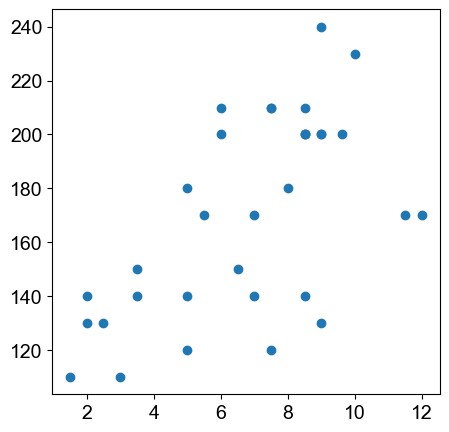

In [10]:
fig = plt.figure(figsize=(5, 5)) 

plt.scatter(all_v0, all_T)
plt.show()

In [20]:
np.corrcoef(all_v0, all_T)

array([[1.       , 0.5999845],
       [0.5999845, 1.       ]])